In [1]:
import sys; sys.path.append('..')
from osp import *
pd.options.display.max_colwidth = 200

In [2]:
df_feats = pd.read_excel('../data/feats_perspectival2.xlsx').drop(columns=['Unnamed: 0']).set_index('feature')
ok_feats = set(df_feats.index) - set(BAD_SLICE_FEATS)
df_feats = df_feats[df_feats.index.isin(ok_feats)]
df_feats['weight_abs'] = df_feats['weight'].abs()
df_feats['score_z_diff_abs'] = df_feats['score_z_diff'].abs()
# df_feats

In [3]:
df_all_feats = get_all_feats()
df_all_feats_raw = get_all_feats(normalize=False)

In [4]:
feat_descs = {feat:FEAT2DESC.get(feat, '') for feat in df_feats.index}
feat_egs = dict(zip(df_feats.index.fillna(''), [x.split(';')[0] for x in df_feats['egs1'].fillna('')]))

In [17]:
def get_label(feature):
    desc = feat_descs.get(feature, '')
    egs = feat_egs.get(feature, '')
    ftype,fname = feature.split('_',1) if '_' in feature else (feature,feature)
    return f'{desc} ({ftype}) [e.g. {egs}]'


In [58]:
df_feats_avg = df_feats.groupby('feature').mean(numeric_only=True).sort_values('weight', ascending=False)
pred_weight_map = df_feats_avg["weight"].to_dict()
weight_map = df_feats_avg["score_z_diff"].to_dict()
weight_map_label = {get_label(k):v for k,v in weight_map.items()}
top_feats = df_feats_avg.sort_values('weight_abs', ascending=False).index.tolist()[:50]
# top_feats

In [32]:

df_all_feats_top = df_all_feats[top_feats]
# df_all_feats_top

df_all_featsT = df_all_feats_top.T.rename_axis('feature')
df_all_featsT['label'] = df_all_featsT.index.map(get_label)
df_all_featsT = df_all_featsT.set_index('label')
# df_all_featsT

<Figure size 3600x2400 with 0 Axes>

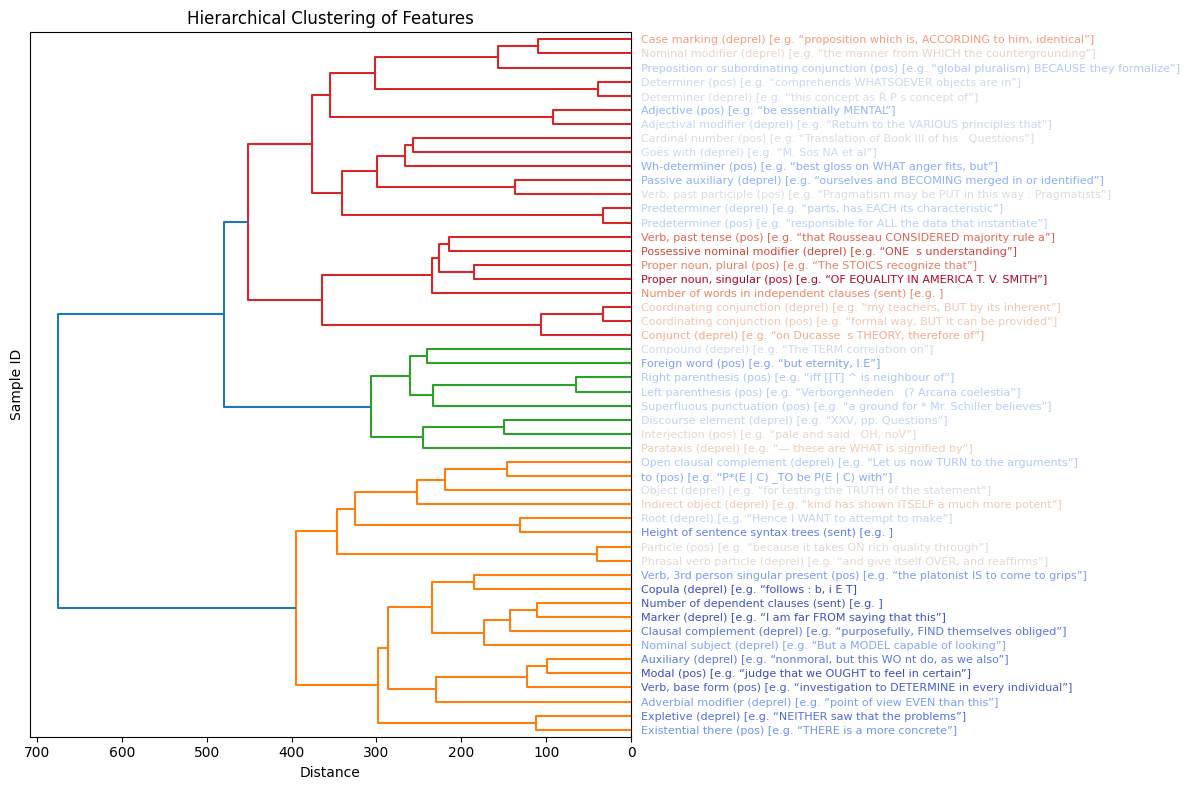

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

# make 300dpi
plt.figure(figsize=(12, 8), dpi=300)

# Standardize the features (already done based on context)
dfx = df_all_featsT
X = dfx.values

# Compute hierarchical clustering
linkage_matrix = linkage(X, method='ward')

# Get feature weight scores for coloring
feat_labels = list(dfx.index)
weights = [weight_map_label.get(f, 0) for f in feat_labels]
wmin, wmax = min(weights), max(weights)

# Normalize weights for colormap
norm = mpl.colors.Normalize(vmin=wmin, vmax=wmax)
cmap = cm.get_cmap("coolwarm_r")  # blue for low (min), red for high (max)

# Plot dendrogram
fig, ax = plt.subplots(figsize=(12, 8))
ddata = dendrogram(linkage_matrix, labels=dfx.index, leaf_font_size=8, orientation='left', ax=ax)

# Color ytick labels (features) according to their weight score
yticklabels = ax.get_yticklabels()
for lab, text in zip(ddata['ivl'], yticklabels):
    # Find weight for this label and color
    try:
        lw = weight_map_label.get(lab, 0)
        color = cmap(norm(lw))
        text.set_color(color)
    except Exception:
        pass

ax.set_title('Hierarchical Clustering of Features')
ax.set_xlabel('Distance')
ax.set_ylabel('Sample ID')
plt.tight_layout()
plt.savefig('../figures/feature_dendrogram.png')
plt.show()

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

# Standardize the features
dfx = df_all_feats_top.T.rename_axis('feature')
X = dfx.values

# Run t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X)

# # Get feature labels and weights for coloring
# feat_labels = list(dfx.index)
# weights = [weight_map_label.get(f, 0) for f in feat_labels]
# wmin, wmax = min(weights), max(weights)

# # Normalize weights for colormap
# norm = mpl.colors.Normalize(vmin=wmin, vmax=wmax)
# cmap = cm.get_cmap("coolwarm_r")

# # Create the plot
# fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

# # Scatter plot colored by weight
# colors = [cmap(norm(w)) for w in weights]
# scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, s=50, alpha=0.7)

# # Add labels for each point
# for i, label in enumerate(feat_labels):
#     ax.annotate(label, (X_tsne[i, 0], X_tsne[i, 1]), 
#                 fontsize=6, alpha=0.8, 
#                 xytext=(3, 3), textcoords='offset points')

# # Add colorbar
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Feature Weight', rotation=270, labelpad=20)

# ax.set_title('t-SNE Visualization of Features')
# ax.set_xlabel('t-SNE Component 1')
# ax.set_ylabel('t-SNE Component 2')
# plt.tight_layout()
# plt.savefig('../figures/feature_tsne.png')
# plt.show()


Running t-SNE...


In [62]:
df_tsne = pd.DataFrame(X_tsne, index=dfx.index)
df_tsne.columns = ['x', 'y']
df_tsne = df_tsne.reset_index()
df_tsne['label'] = df_tsne['feature'].map(get_label)
df_tsne['weight'] = [weight_map.get(f, 0) for f in df_tsne['feature']]
df_tsne['pred_weight'] = [pred_weight_map.get(f, 0) for f in df_tsne['feature']]
df_tsne['pred_weight_abs'] = df_tsne['pred_weight'].abs()

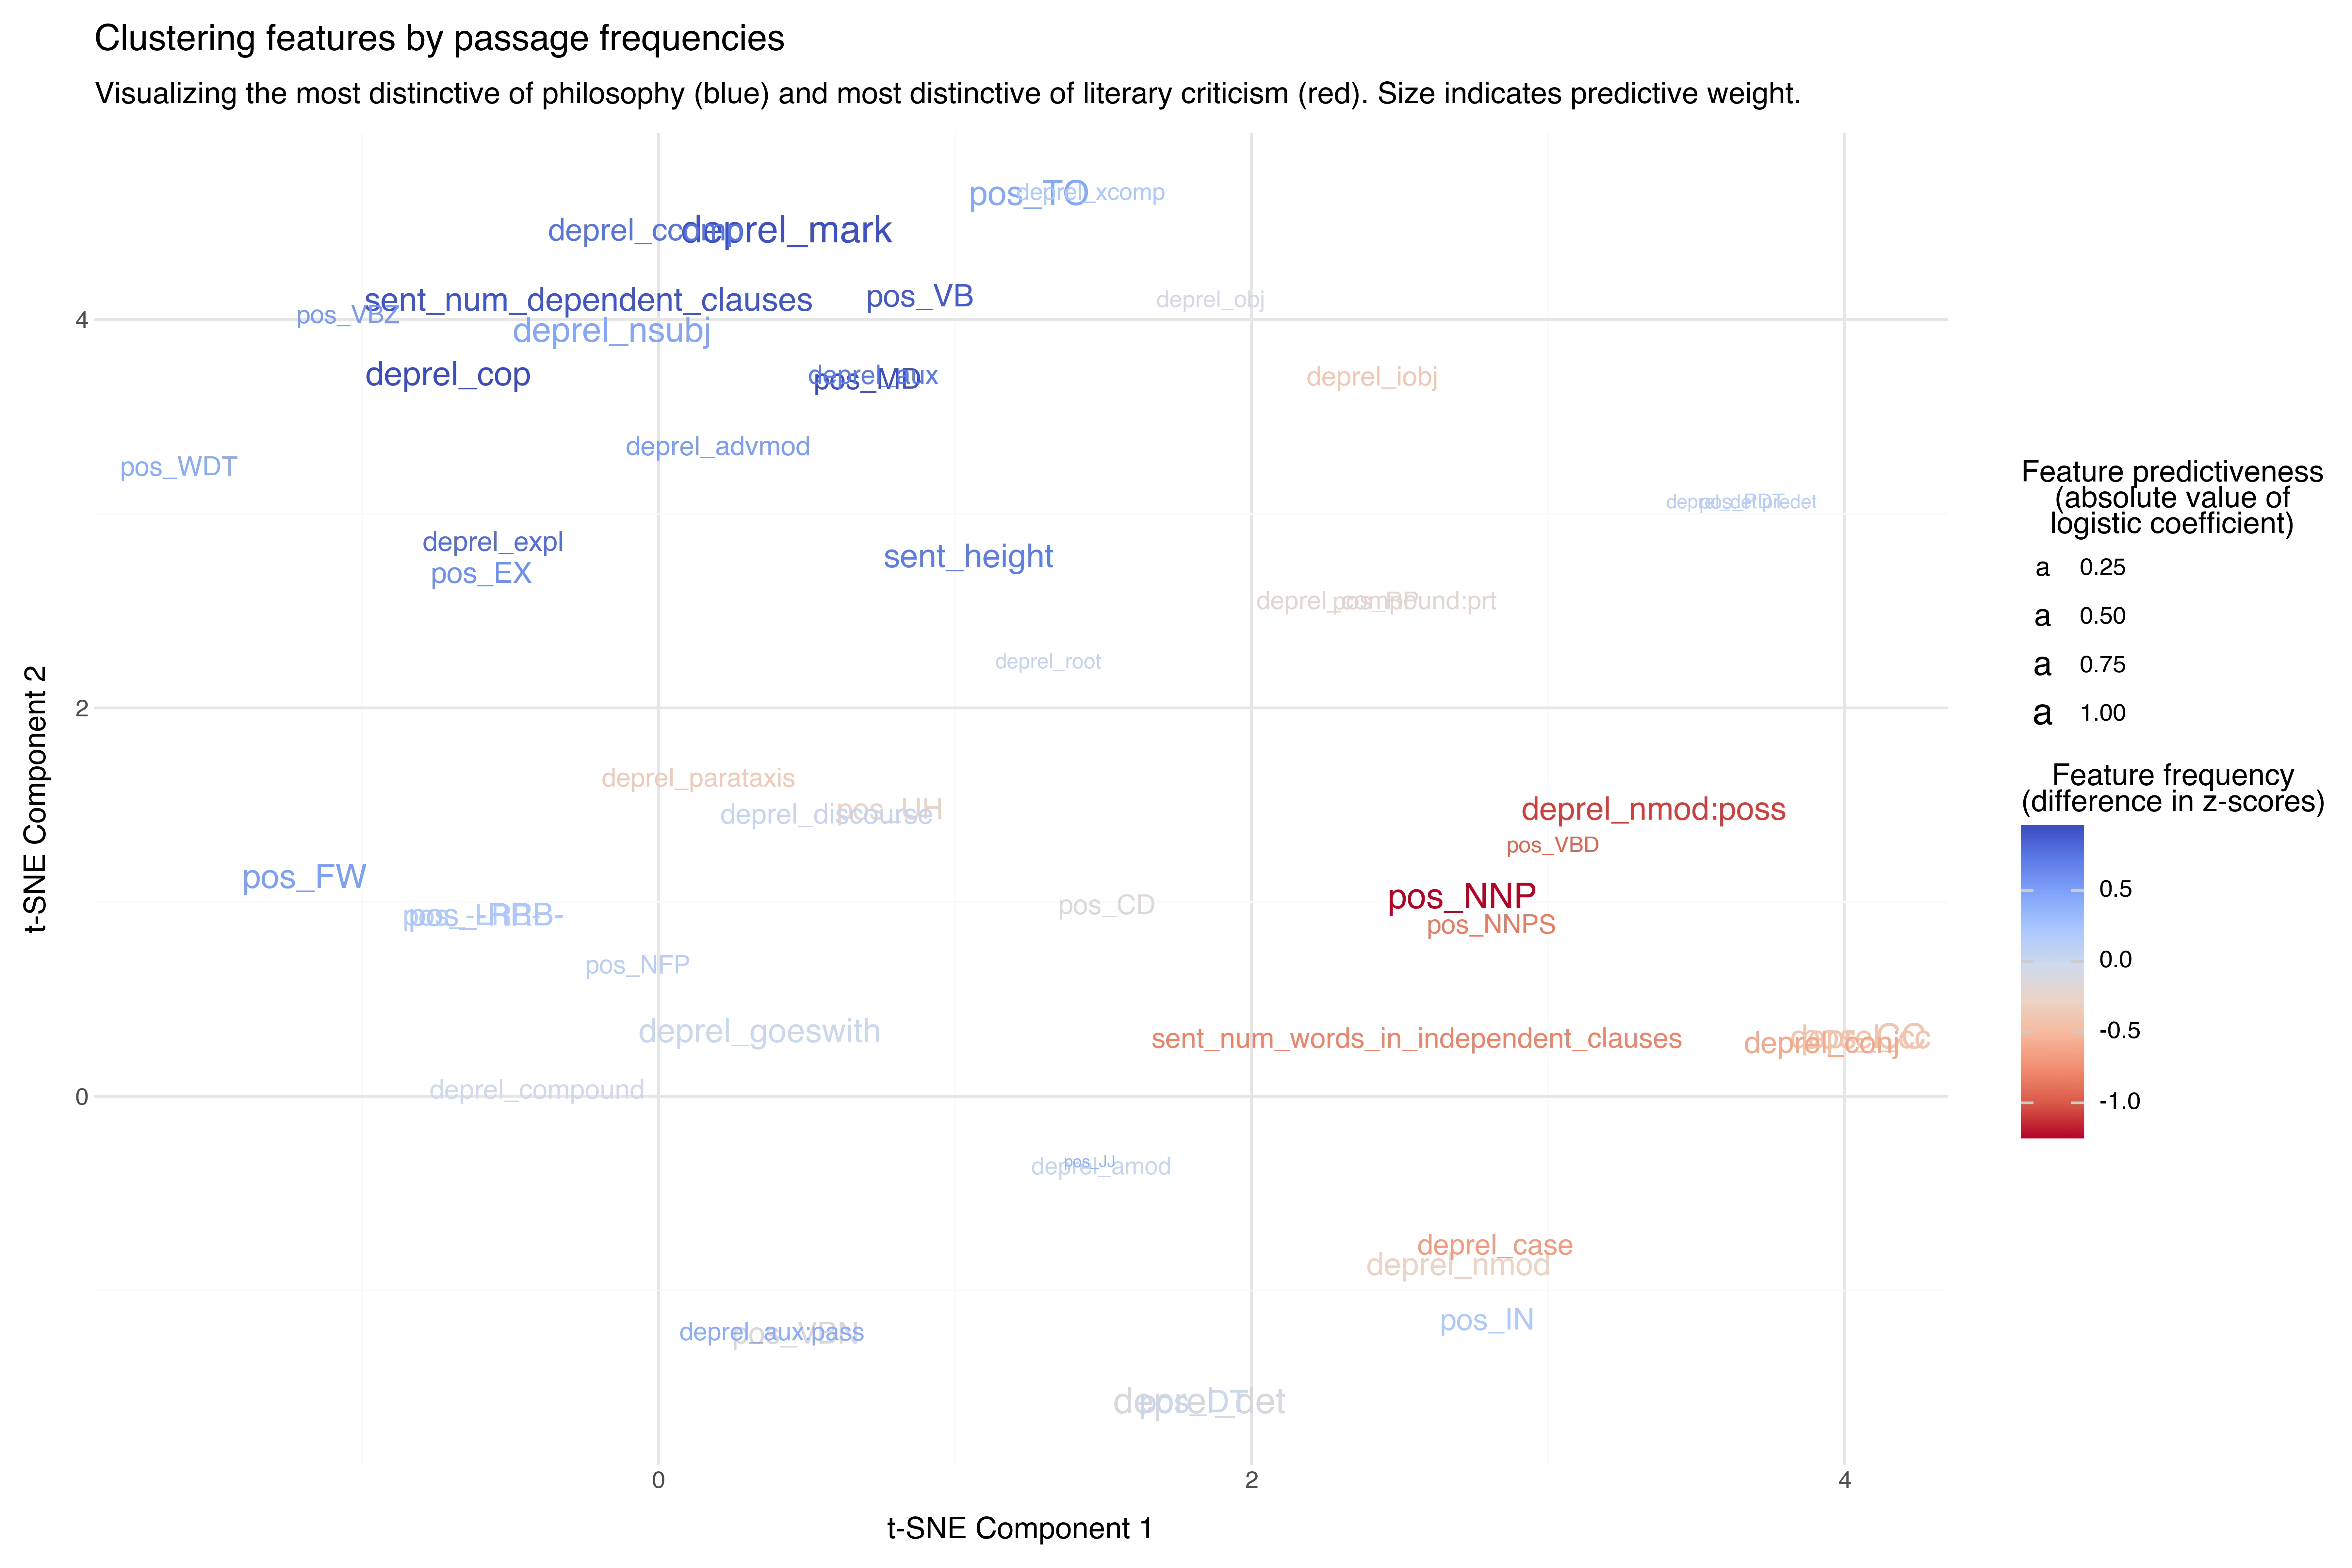

In [77]:
p9.options.figure_size = (12, 8)
fig = p9.ggplot(
    df_tsne,
    p9.aes(x='x', y='y', label='feature',color='weight',size='pred_weight_abs')
)
fig += p9.geom_text()
fig += p9.theme_minimal()
# fig += p9.scale_color_brewer()
fig += p9.scale_size_continuous(range=(6, 14))
fig += p9.scale_color_gradientn(colors=cmap(np.linspace(0, 1, 10)))
fig += p9.labs(
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    color='Feature frequency\n(difference in z-scores)',
    size='Feature predictiveness\n(absolute value of\nlogistic coefficient)',
    title='Clustering features by passage frequencies',
    subtitle='Visualizing the most distinctive of philosophy (blue) and most distinctive of literary criticism (red). Size indicates predictive weight.'
)
fig.save('../figures/feature_tsne.png')
fig